In [1]:
# analysis
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.integrate import odeint

# plotting
import cmocean.cm as cm
from matplotlib import rc, rcParams
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25)
import matplotlib.ticker as ticker


# Summary of parameter sensitivity (figures - descriptions provided in SI)


In [2]:
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=18) 
rc('ytick', labelsize=18) 
rc('axes', labelsize=18)

In [3]:
def analytical_hWW(Ψin, α, κP, H=700, L=5e4):
    hWW = H/2 - Ψin/(2*α)+np.sqrt((H/2 - Ψin/(2*α))**2+κP*L/(α))
    return hWW
def analytical_bWW(hWW, Ψin, α, κP, Fsurf, H=700, L=5e4, bmelt=0.0067):
    bWW = (hWW - Ψin/α)*(Fsurf*L/(2*Ψin)+bmelt)/(κP*L/(2*Ψin)+H/2-Ψin/α) - bmelt
    return bWW
def analytical_phase_space(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params):
    L=params["L"];H = params["H"]; κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"];
    Ψin          = np.linspace(Ψin_min,Ψin_max,n)
    Fsurf        = np.linspace(Fsurf_min,Fsurf_max,n)
    Ψin_grid, Fsurf_grid = np.meshgrid(Ψin,Fsurf)
    hWW_diffusive = analytical_hWW(Ψin_grid, α, κP=κ_diff, H=700, L=5e4)
    bWW_diffusive = analytical_bWW(hWW_diffusive, Ψin_grid, α, κ_diff, Fsurf_grid, H=700, L=5e4, bmelt=b_melt)
    hWW_convective = analytical_hWW(Ψin_grid, α, κP=κ_conv, H=700, L=5e4)
    bWW_convective = analytical_bWW(hWW_convective, Ψin_grid, α, κ_conv, Fsurf_grid, H=700, L=5e4, bmelt=b_melt)
    bWW_diffusive = np.where(bWW_diffusive>b_crit,bWW_diffusive,np.nan)
    hWW_diffusive = hWW_diffusive*(bWW_diffusive*0+1)
    bWW_convective = np.where(bWW_convective<b_crit,bWW_convective,np.nan)
    hWW_convective = hWW_convective*(bWW_convective*0+1)
    return Ψin, Fsurf,hWW_diffusive,bWW_diffusive,hWW_convective,bWW_convective

In [16]:
def sensitivity_plots(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params_control, params_positive,params_negative):
    
    Ψin, Fsurf,hWW_diffusive_control,bWW_diffusive_control,hWW_convective_control,bWW_convective_control = analytical_phase_space(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params)
    _, _,hWW_diffusive_positive,bWW_diffusive_positive,hWW_convective_positive,bWW_convective_positive = analytical_phase_space(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params_positive)
    _, _,hWW_diffusive_negative,bWW_diffusive_negative,hWW_convective_negative,bWW_convective_negative = analytical_phase_space(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params_negative)

    region_diff = hWW_diffusive_control*0+1;region_conv = hWW_convective_control*0+1
    region_control = np.nan_to_num(region_diff*region_conv)

    region_diff = hWW_diffusive_positive*0+1;region_conv = hWW_convective_positive*0+1
    region_positive = np.nan_to_num(region_diff*region_conv)

    region_diff = hWW_diffusive_negative*0+1;region_conv = hWW_convective_negative*0+1
    region_negative = np.nan_to_num(region_diff*region_conv)
    
    fig, axs = plt.subplots(4,3, figsize=(16,20))
    translation = 1e6/(55*1e3)

    h_levels = np.arange(0,900,100)
    b_levels = np.arange(-500,500,10)*1e-4

    L=params["L"];H = params["H"]; κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"];
    
    c1=axs[0,1].pcolormesh(Ψin/translation,Fsurf*1e7,hWW_diffusive_control, cmap=cm.deep, vmin=0,vmax=H)
    axs[0,1].contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive_control, levels=h_levels, colors=['k'])
    axs[0,1].contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive_control, levels=[700], colors=['pink'])
    axs[1,1].pcolormesh(Ψin/translation,Fsurf*1e7,hWW_convective_control, cmap=cm.deep, vmin=0,vmax=H)
    axs[1,1].contour(Ψin/translation,Fsurf*1e7 ,hWW_convective_control, levels=h_levels, colors=['k'])
    axs[1,1].contour(Ψin/translation,Fsurf*1e7 ,hWW_convective_control, levels=[700], colors=['pink'])


    axs[0,0].pcolormesh(Ψin/translation,Fsurf*1e7,hWW_diffusive_negative, cmap=cm.deep, vmin=0,vmax=H)
    axs[0,0].contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive_negative, levels=h_levels, colors=['k'])
    axs[0,0].contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive_negative, levels=[700], colors=['pink'])
    axs[1,0].pcolormesh(Ψin/translation,Fsurf*1e7,hWW_convective_negative, cmap=cm.deep, vmin=0,vmax=H)
    axs[1,0].contour(Ψin/translation,Fsurf*1e7 ,hWW_convective_negative, levels=h_levels, colors=['k'])
    axs[1,0].contour(Ψin/translation,Fsurf*1e7 ,hWW_convective_negative, levels=[700], colors=['pink'])

    axs[0,2].pcolormesh(Ψin/translation,Fsurf*1e7,hWW_diffusive_positive, cmap=cm.deep, vmin=0,vmax=H)
    axs[0,2].contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive_positive, levels=h_levels, colors=['k'])
    axs[0,2].contour(Ψin/translation,Fsurf*1e7 ,hWW_diffusive_positive, levels=[700], colors=['pink'])
    axs[1,2].pcolormesh(Ψin/translation,Fsurf*1e7,hWW_convective_positive, cmap=cm.deep, vmin=0,vmax=H)
    axs[1,2].contour(Ψin/translation,Fsurf*1e7 ,hWW_convective_positive, levels=h_levels, colors=['k'])
    axs[1,2].contour(Ψin/translation,Fsurf*1e7 ,hWW_convective_positive, levels=[700], colors=['pink'])


    c2=axs[2,1].pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_control,cmap='bwr', vmin=-8*1e-3, vmax=8*1e-3)
    axs[2,1].contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_control, levels=b_levels, colors=['k'])
    axs[2,1].contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_control, levels=[b_melt], colors=['w'])
    axs[3,1].pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_convective_control,cmap='bwr', vmin=-8*1e-3, vmax=8*1e-3)
    axs[3,1].contour(Ψin/translation,Fsurf*1e7 ,bWW_convective_control, levels=b_levels, colors=['k'])
    axs[3,1].contour(Ψin/translation,Fsurf*1e7 ,bWW_convective_control, levels=[b_melt], colors=['w'])

    axs[2,0].pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_negative,cmap='bwr', vmin=-8*1e-3, vmax=8*1e-3)
    axs[2,0].contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_negative, levels=b_levels, colors=['k'])
    axs[2,0].contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_negative, levels=[b_melt], colors=['w'])
    axs[3,0].pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_convective_negative,cmap='bwr', vmin=-8*1e-3, vmax=8*1e-3)
    axs[3,0].contour(Ψin/translation,Fsurf*1e7 ,bWW_convective_negative, levels=b_levels, colors=['k'])
    axs[3,0].contour(Ψin/translation,Fsurf*1e7 ,bWW_convective_negative, levels=[b_melt], colors=['w'])

    axs[2,2].pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_positive,cmap='bwr', vmin=-8*1e-3, vmax=8*1e-3)
    axs[2,2].contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_positive, levels=b_levels, colors=['k'])
    axs[2,2].contour(Ψin/translation,Fsurf*1e7 ,bWW_diffusive_positive, levels=[b_melt], colors=['w'])
    axs[3,2].pcolormesh(Ψin/translation,Fsurf*1e7 ,bWW_convective_positive,cmap='bwr', vmin=-8*1e-3, vmax=8*1e-3)
    axs[3,2].contour(Ψin/translation,Fsurf*1e7 ,bWW_convective_positive, levels=b_levels, colors=['k'])
    axs[3,2].contour(Ψin/translation,Fsurf*1e7 ,bWW_convective_positive, levels=[b_melt], colors=['w'])

    axs[0,0].contour(Ψin/translation,Fsurf*1e7,region_negative, levels=[0,3],colors='yellow',linewidths=3)
    axs[1,0].contour(Ψin/translation,Fsurf*1e7,region_negative, levels=[0,3],colors='yellow',linewidths=3)
    axs[2,0].contour(Ψin/translation,Fsurf*1e7,region_negative, levels=[0,3],colors='yellow',linewidths=3)
    axs[3,0].contour(Ψin/translation,Fsurf*1e7,region_negative, levels=[0,3],colors='yellow',linewidths=3)

    axs[0,1].contour(Ψin/translation,Fsurf*1e7,region_control, levels=[0,3],colors='yellow',linewidths=3)
    axs[1,1].contour(Ψin/translation,Fsurf*1e7,region_control, levels=[0,3],colors='yellow',linewidths=3)
    axs[2,1].contour(Ψin/translation,Fsurf*1e7,region_control, levels=[0,3],colors='yellow',linewidths=3)
    axs[3,1].contour(Ψin/translation,Fsurf*1e7,region_control, levels=[0,3],colors='yellow',linewidths=3)

    axs[0,2].contour(Ψin/translation,Fsurf*1e7,region_positive, levels=[0,3],colors='yellow',linewidths=3)
    axs[1,2].contour(Ψin/translation,Fsurf*1e7,region_positive, levels=[0,3],colors='yellow',linewidths=3)
    axs[2,2].contour(Ψin/translation,Fsurf*1e7,region_positive, levels=[0,3],colors='yellow',linewidths=3)
    axs[3,2].contour(Ψin/translation,Fsurf*1e7,region_positive, levels=[0,3],colors='yellow',linewidths=3)
    f=18
    
    ax = axs[0,2].twinx();ax1 = axs[1,2].twinx();ax.set_yticks([]);ax1.set_yticks([])
    ax.set_ylabel('Diffusive Steady States', rotation=-90,labelpad=25,fontsize=20)
    ax1.set_ylabel('Convective Steady States', rotation=-90,labelpad=25,fontsize=20)

    ax = axs[2,2].twinx();ax1 = axs[3,2].twinx();ax.set_yticks([]);ax1.set_yticks([])
    ax.set_ylabel('Diffusive Steady States', rotation=-90,labelpad=25,fontsize=20)
    ax1.set_ylabel('Convective Steady States', rotation=-90,labelpad=25,fontsize=20)

    cax = fig.add_axes([0.15, -0.02, 0.3, 0.015])
    cbar=plt.colorbar(c1,cax = cax,orientation='horizontal',shrink = 0.5)
    cbar.set_label('$h\; [\mathrm{m}] $ (thermocline depth)', fontsize = f)
    cax = fig.add_axes([0.55, -0.02, 0.3, 0.015])
    cbar=plt.colorbar(c2,cax = cax,orientation='horizontal',shrink = 0.5)
    cbar.set_label('$\Delta b\; [\mathrm{m}\mathrm{s}^{-2}] $ (stratification)', fontsize = f)


    axs[0,0].set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
    axs[1,0].set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
    axs[2,0].set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
    axs[3,0].set_ylabel('$F_\mathrm{surf}\; [10^{-7} \;\mathrm{m}^{2}\;\mathrm{ s}^{-3}]$', fontsize=f)
    axs[3,0].set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
    axs[3,1].set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
    axs[3,2].set_xlabel('$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=f)
    fig.tight_layout()
    
    return axs[0,0], axs[0,1], axs[0,2]

#     plt.show()

# Sensitivity to $\alpha$



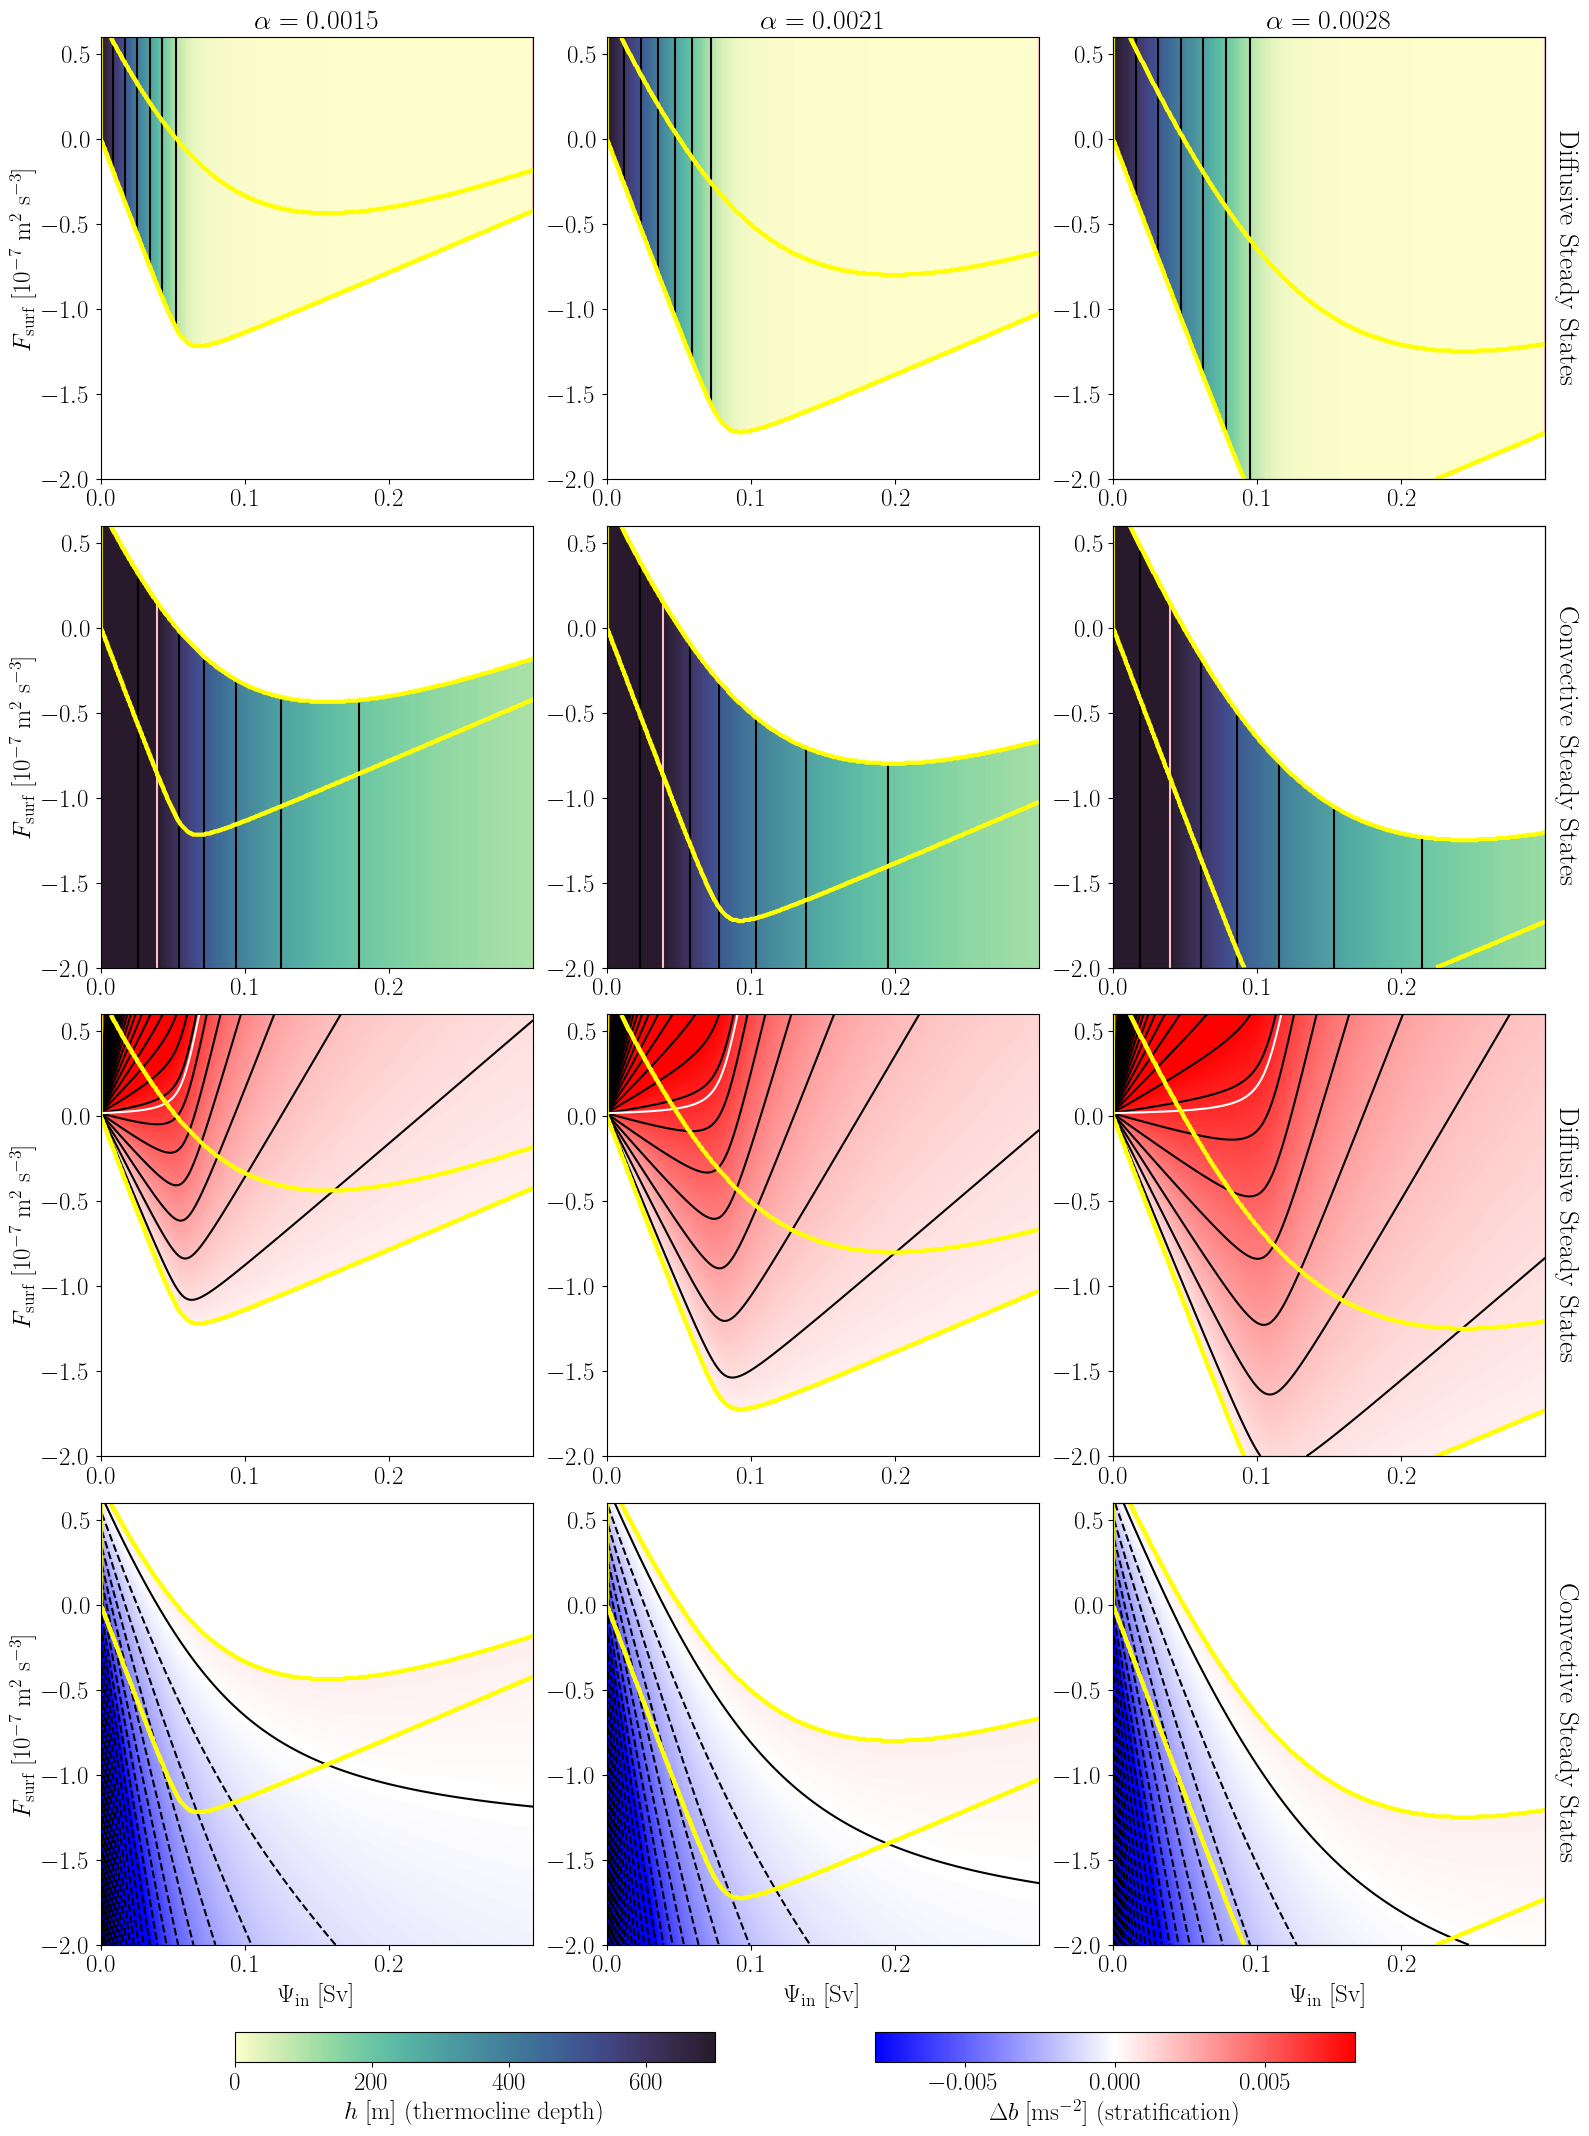

In [17]:
Ψin_min=0;Ψin_max=5.45;Fsurf_min=-2e-7;Fsurf_max=6e-8; n=400 

### here is where you can test other magnitudes of parameter perturbations (edit value of α in params_negative and params_positive), similarly in other cells
params_negative = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0015}
params          = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params_positive = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0028}

ax,ax1,ax2 = sensitivity_plots(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params, params_positive,params_negative)
ax.set_title(r'$\alpha=0.0015$',fontsize=20)
ax1.set_title(r'$\alpha=0.0021$',fontsize=20)
ax2.set_title(r'$\alpha=0.0028$',fontsize=20)
# plt.savefig('Figure_S3.png',bbox_inches = "tight")

plt.show()

# Sensitivity to $\kappa_\mathrm{diff}$ and $\kappa_\mathrm{conv}$


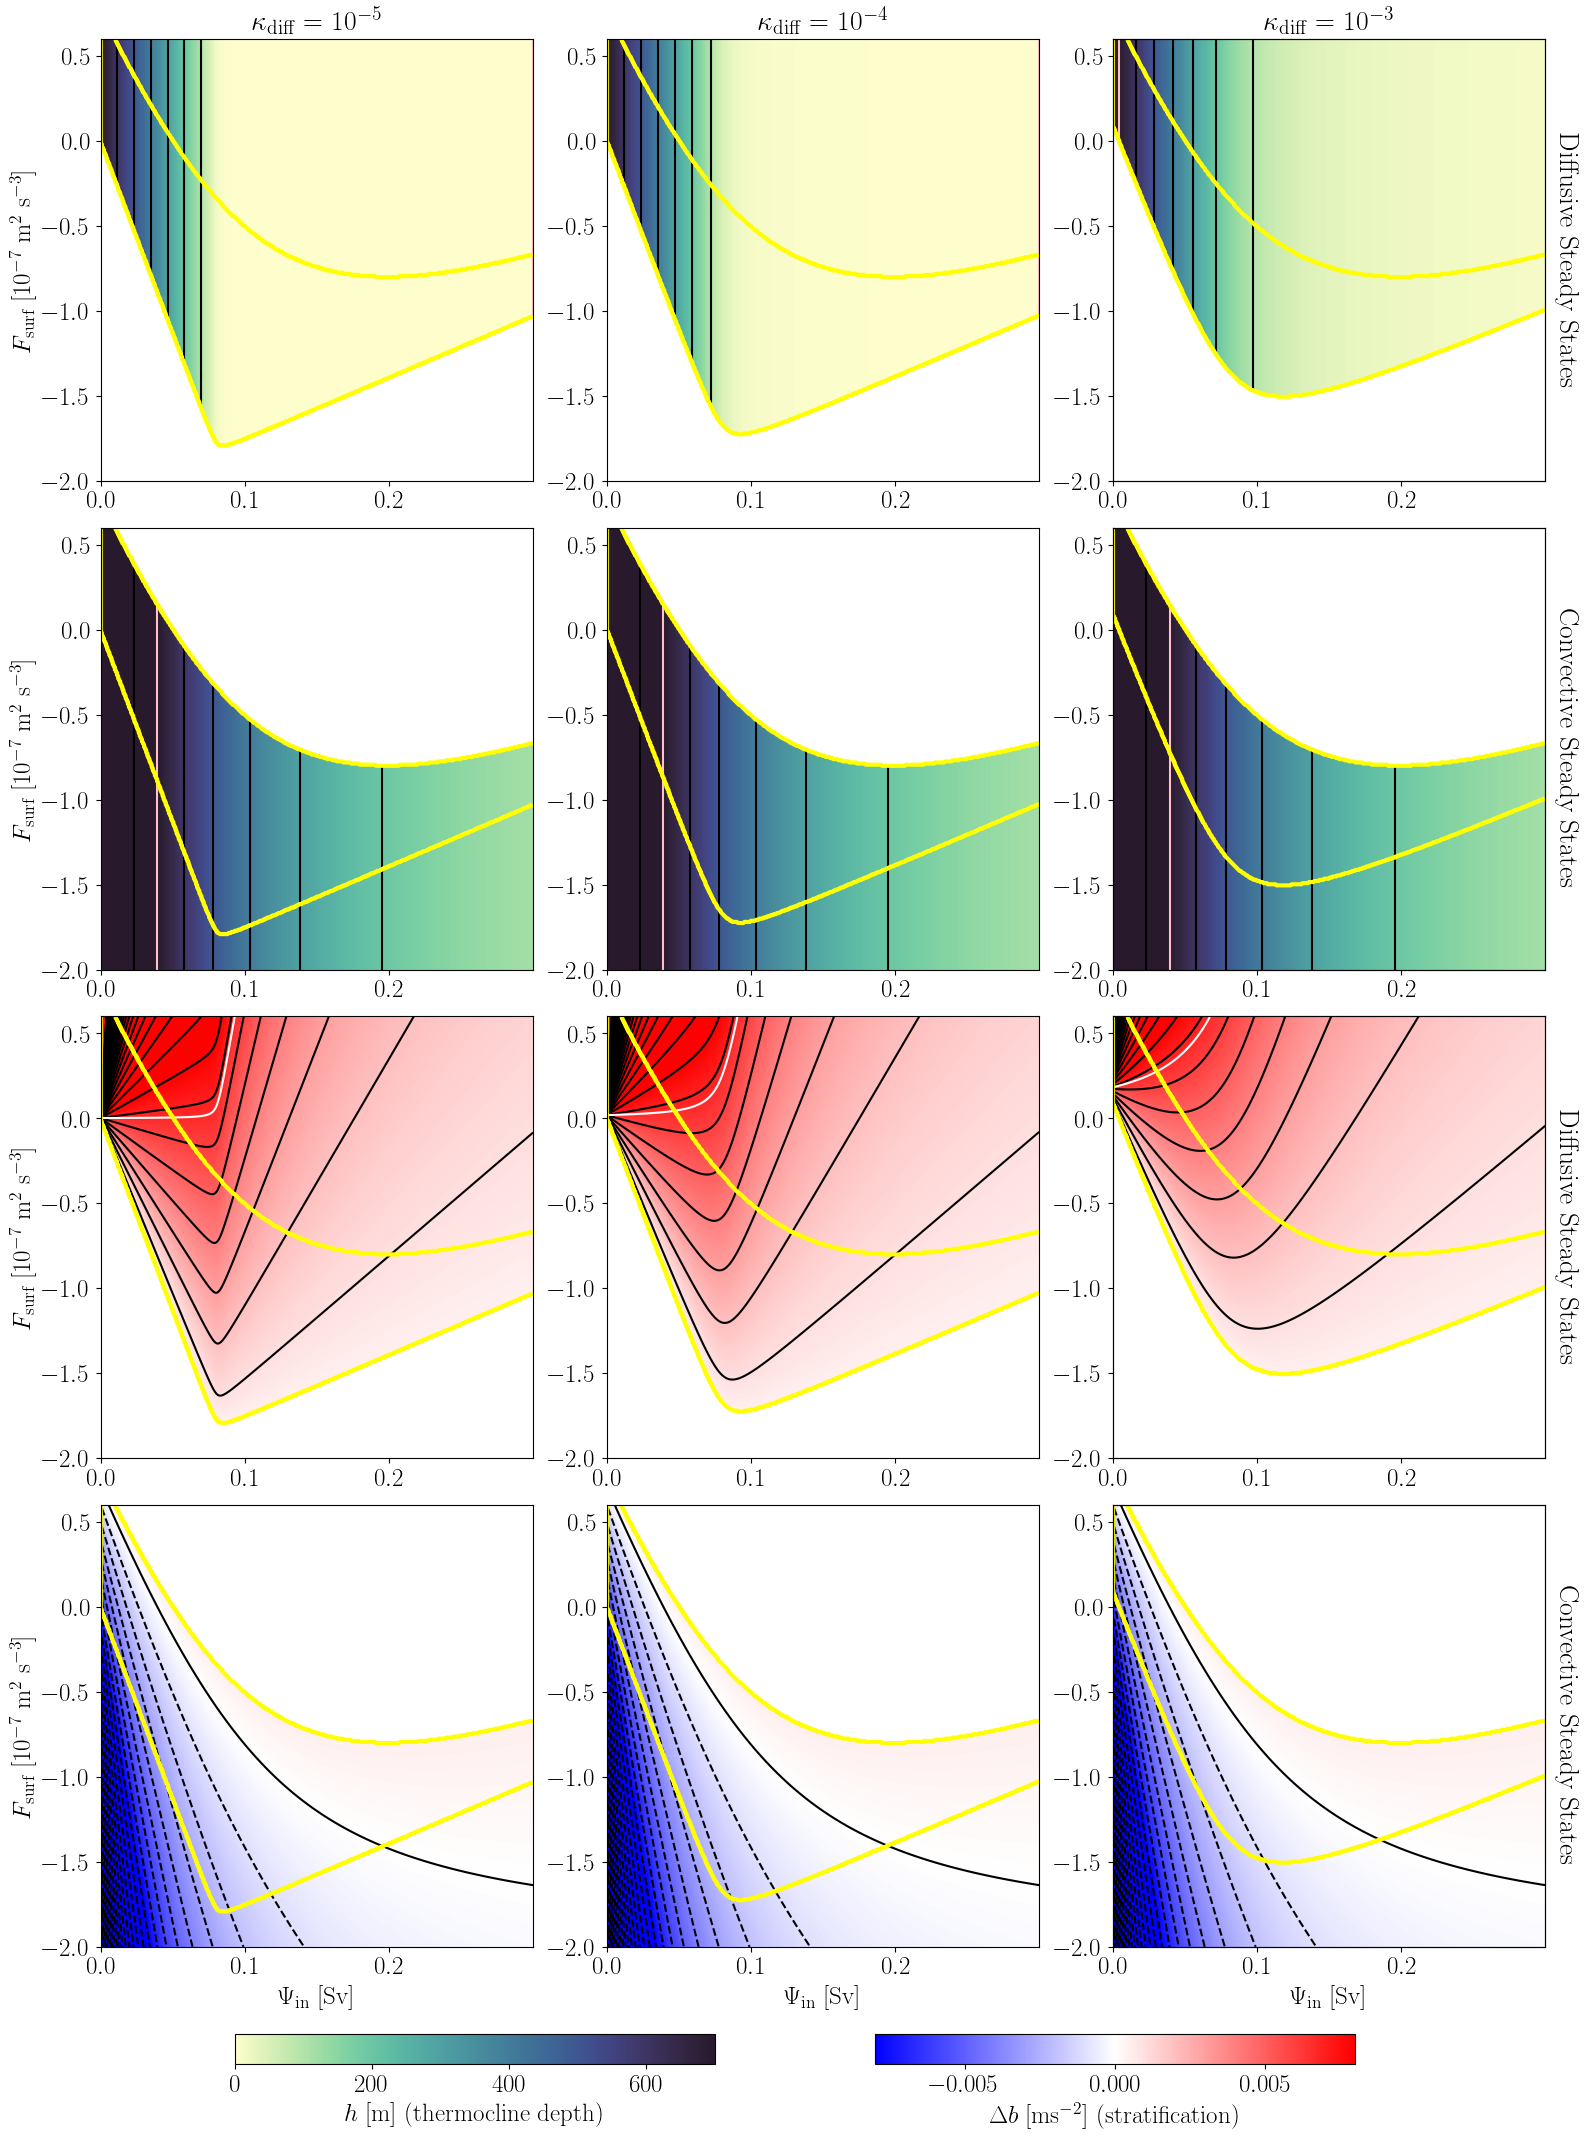

In [9]:
Ψin_min=0;Ψin_max=5.45;Fsurf_min=-2e-7;Fsurf_max=6e-8; n=400 

params_negative = {"L":0.5e5, "H":700, "κ_diff":1e-5, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params          = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params_positive = {"L":0.5e5, "H":700, "κ_diff":1e-3, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}

ax,ax1,ax2 = sensitivity_plots(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params, params_positive,params_negative)
ax.set_title(r'$\kappa_\mathrm{diff}= 10^{-5}$',fontsize=20)
ax1.set_title(r'$\kappa_\mathrm{diff}=10^{-4}$',fontsize=20)
ax2.set_title(r'$\kappa_\mathrm{diff}= 10^{-3}$',fontsize=20)
# plt.savefig('Figure_S3.png',bbox_inches = "tight")

plt.show()

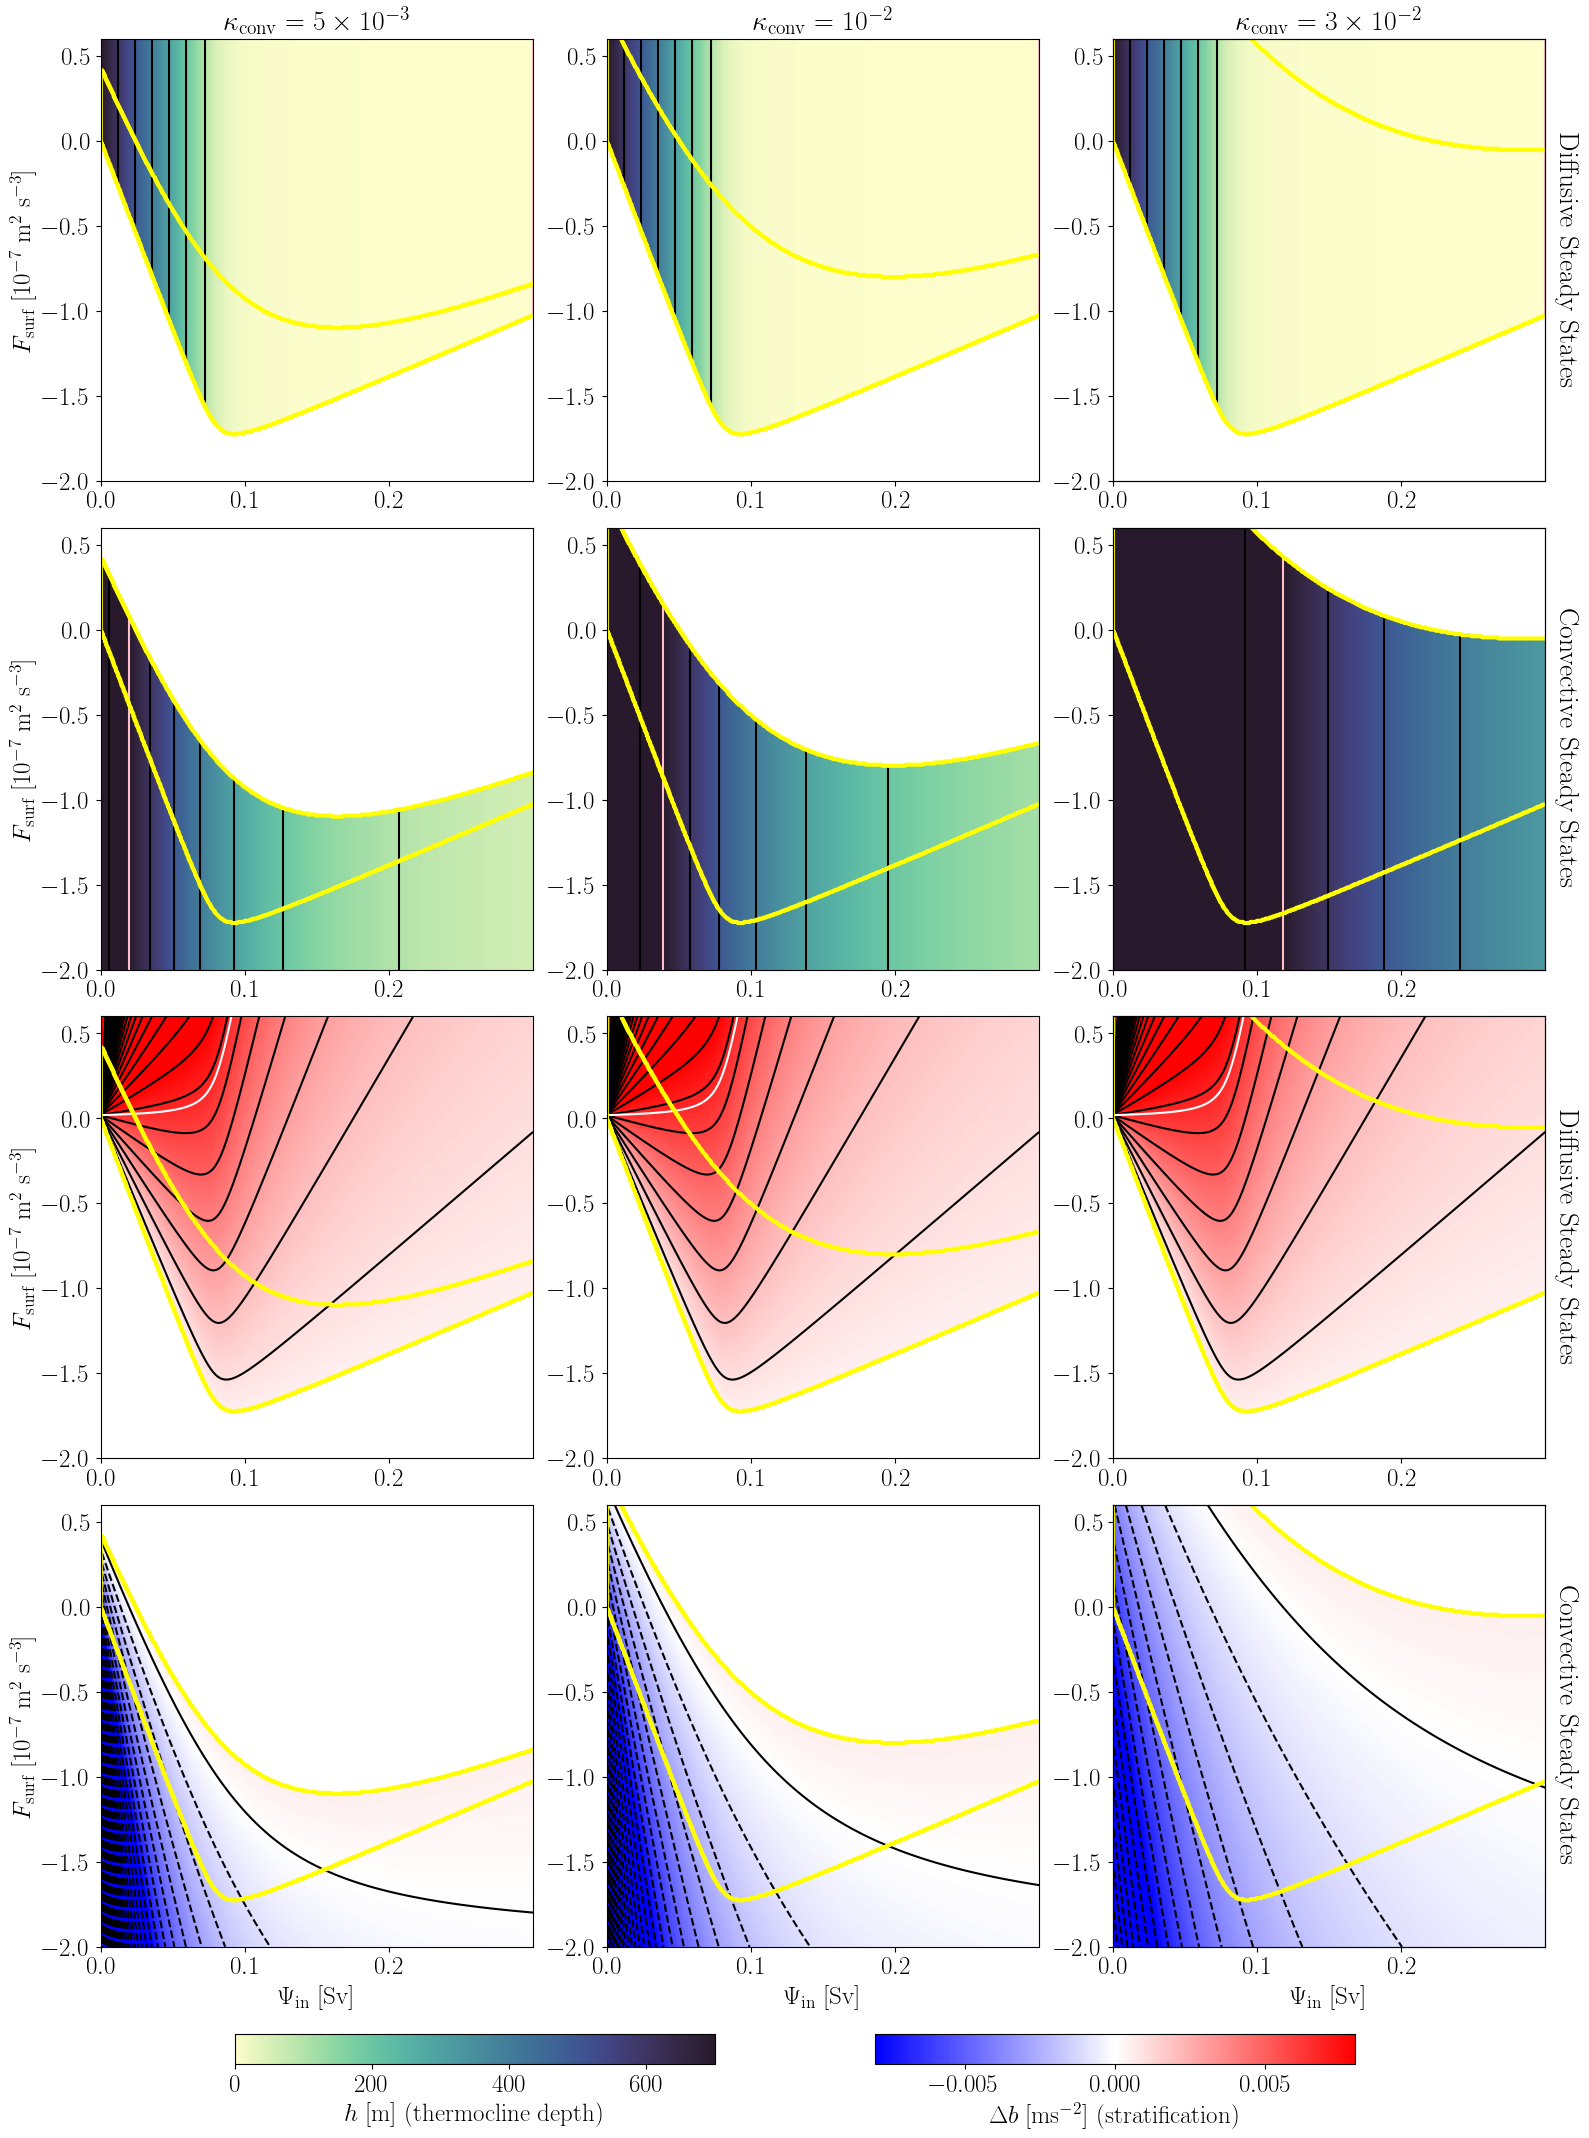

In [11]:
Ψin_min=0;Ψin_max=5.45;Fsurf_min=-2e-7;Fsurf_max=6e-8; n=400 

params_negative = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":5e-3, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params          = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params_positive = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":3e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}

ax,ax1,ax2 = sensitivity_plots(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params, params_positive,params_negative)
ax.set_title(r'$\kappa_\mathrm{conv}= 5\times 10^{-3}$',fontsize=20)
ax1.set_title(r'$\kappa_\mathrm{conv}=10^{-2}$',fontsize=20)
ax2.set_title(r'$\kappa_\mathrm{conv}= 3\times 10^{-2}$',fontsize=20)
# plt.savefig('Figure_S3.png',bbox_inches = "tight")

plt.show()

# Sensitivity to $b_\mathrm{melt}$



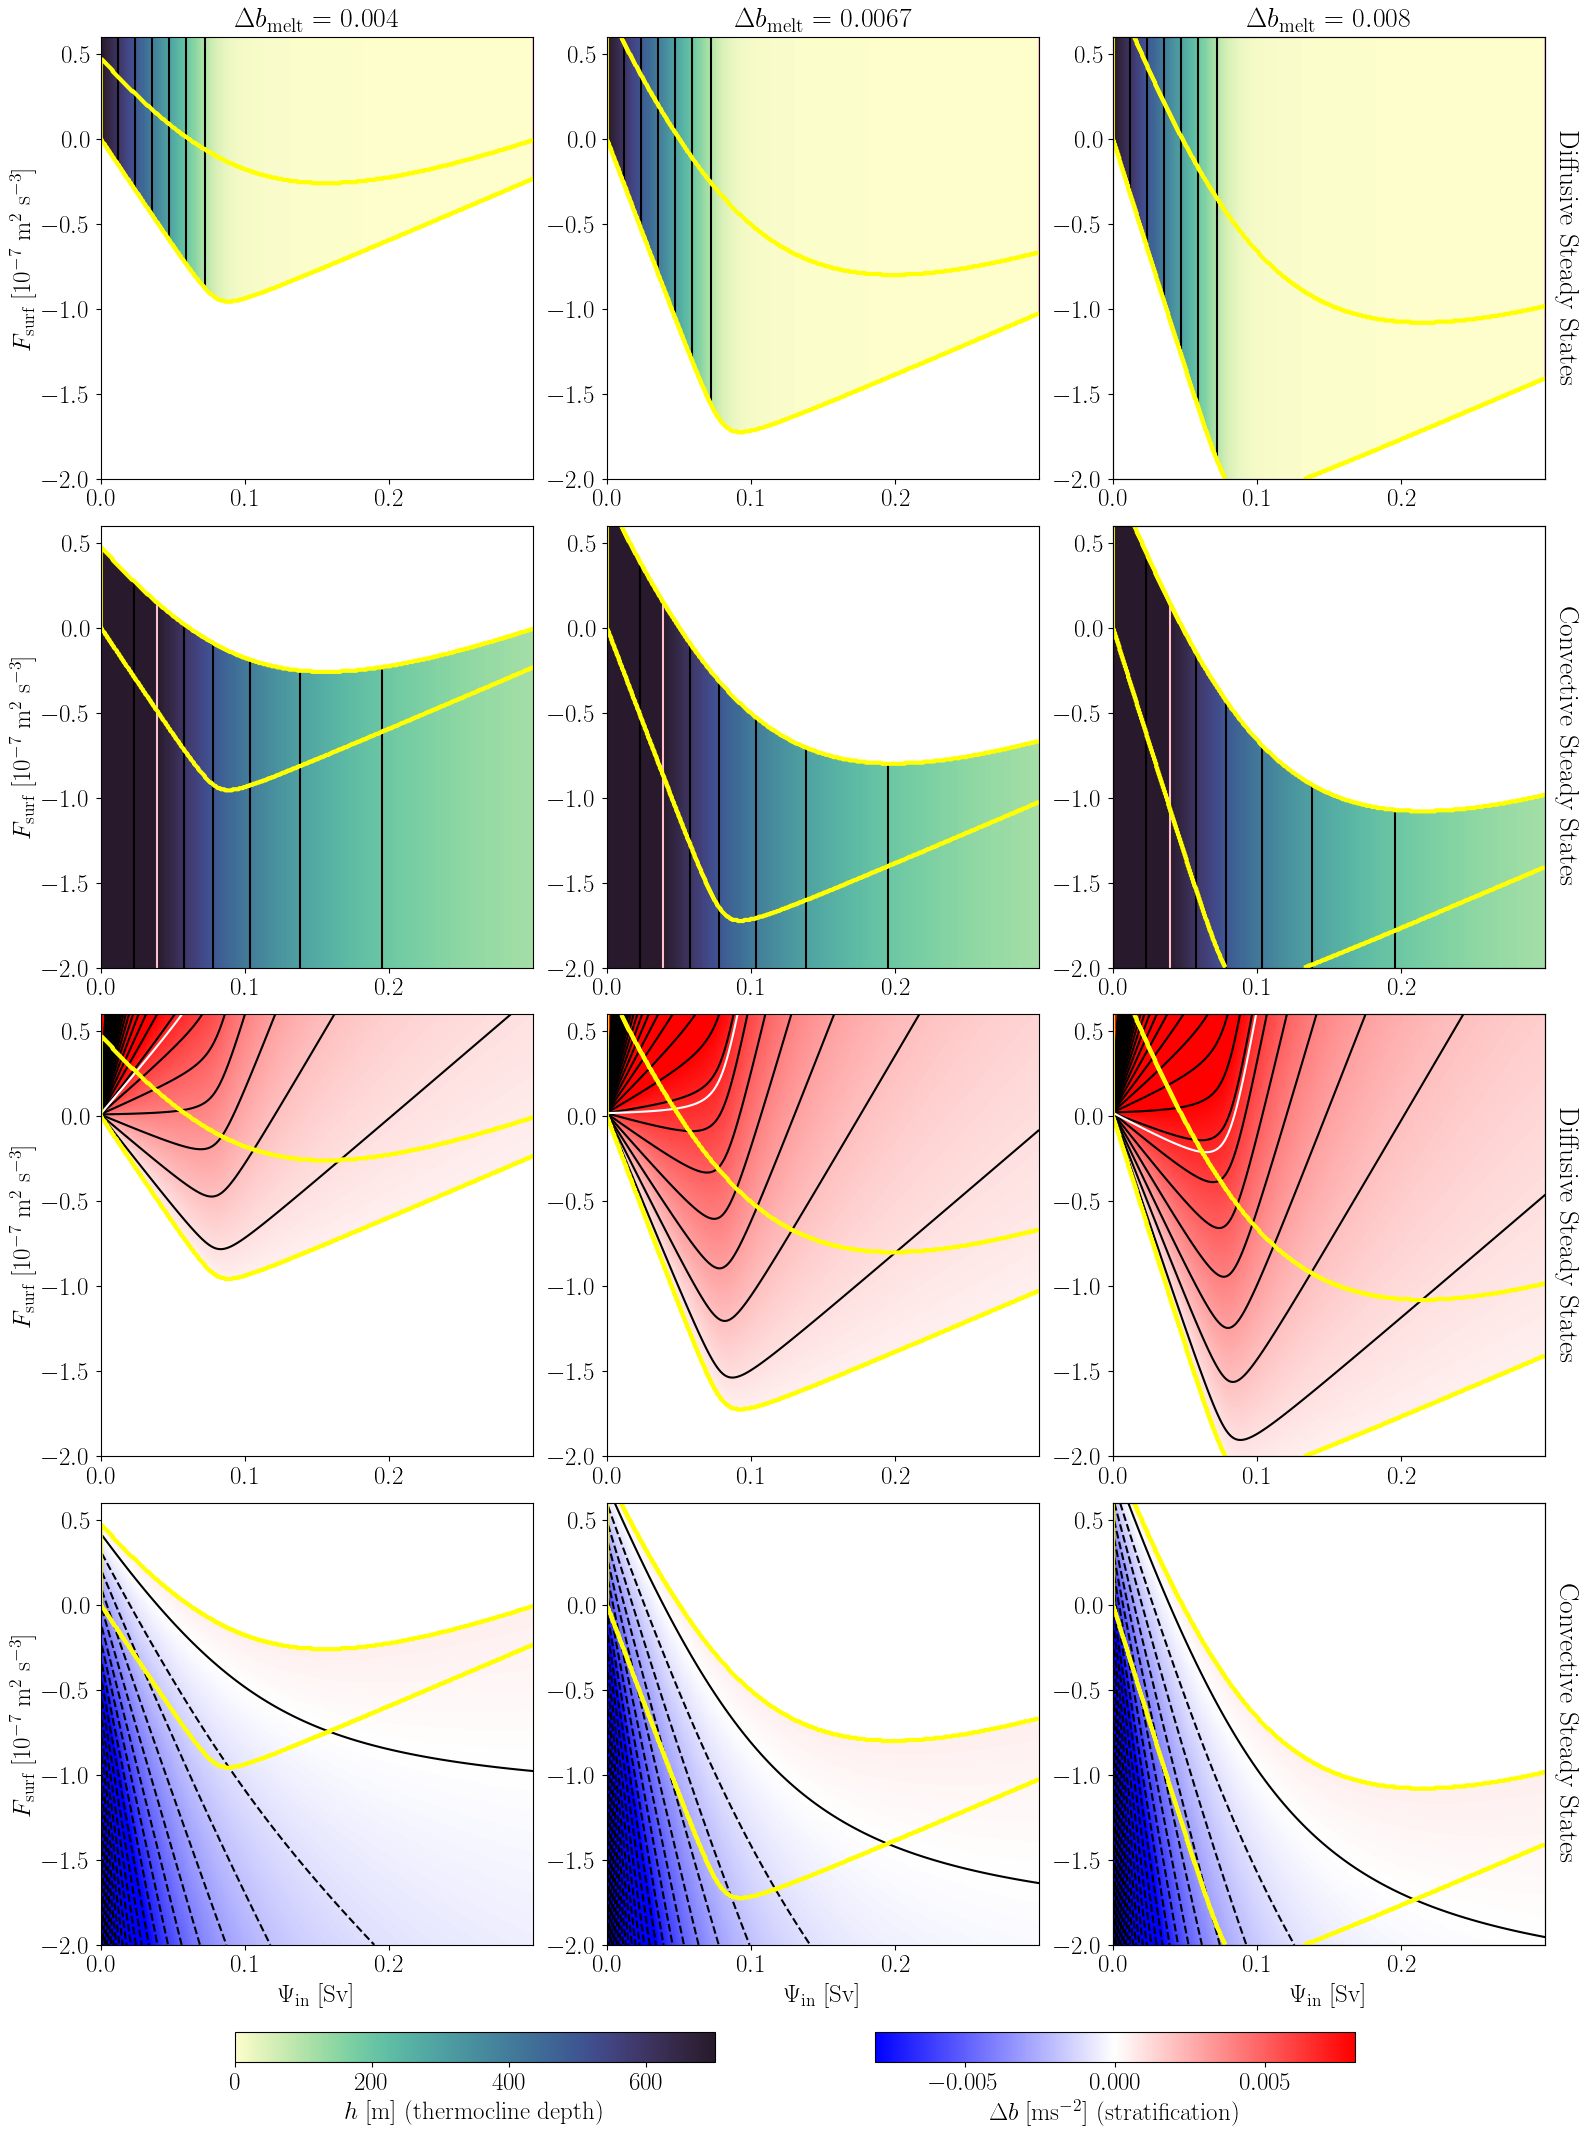

In [12]:
Ψin_min=0;Ψin_max=5.45;Fsurf_min=-2e-7;Fsurf_max=6e-8; n=400 

params_negative = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.004, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params          = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params_positive = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.008, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}

ax,ax1,ax2 = sensitivity_plots(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params, params_positive,params_negative)
ax.set_title(r'$\Delta b_\mathrm{melt}= 0.004$',fontsize=20)
ax1.set_title(r'$\Delta b_\mathrm{melt}=0.0067$',fontsize=20)
ax2.set_title(r'$\Delta b_\mathrm{melt}= 0.008$',fontsize=20)
# plt.savefig('Figure_S3.png',bbox_inches = "tight")

plt.show()

# Sensitivity to $b_\mathrm{crit}$


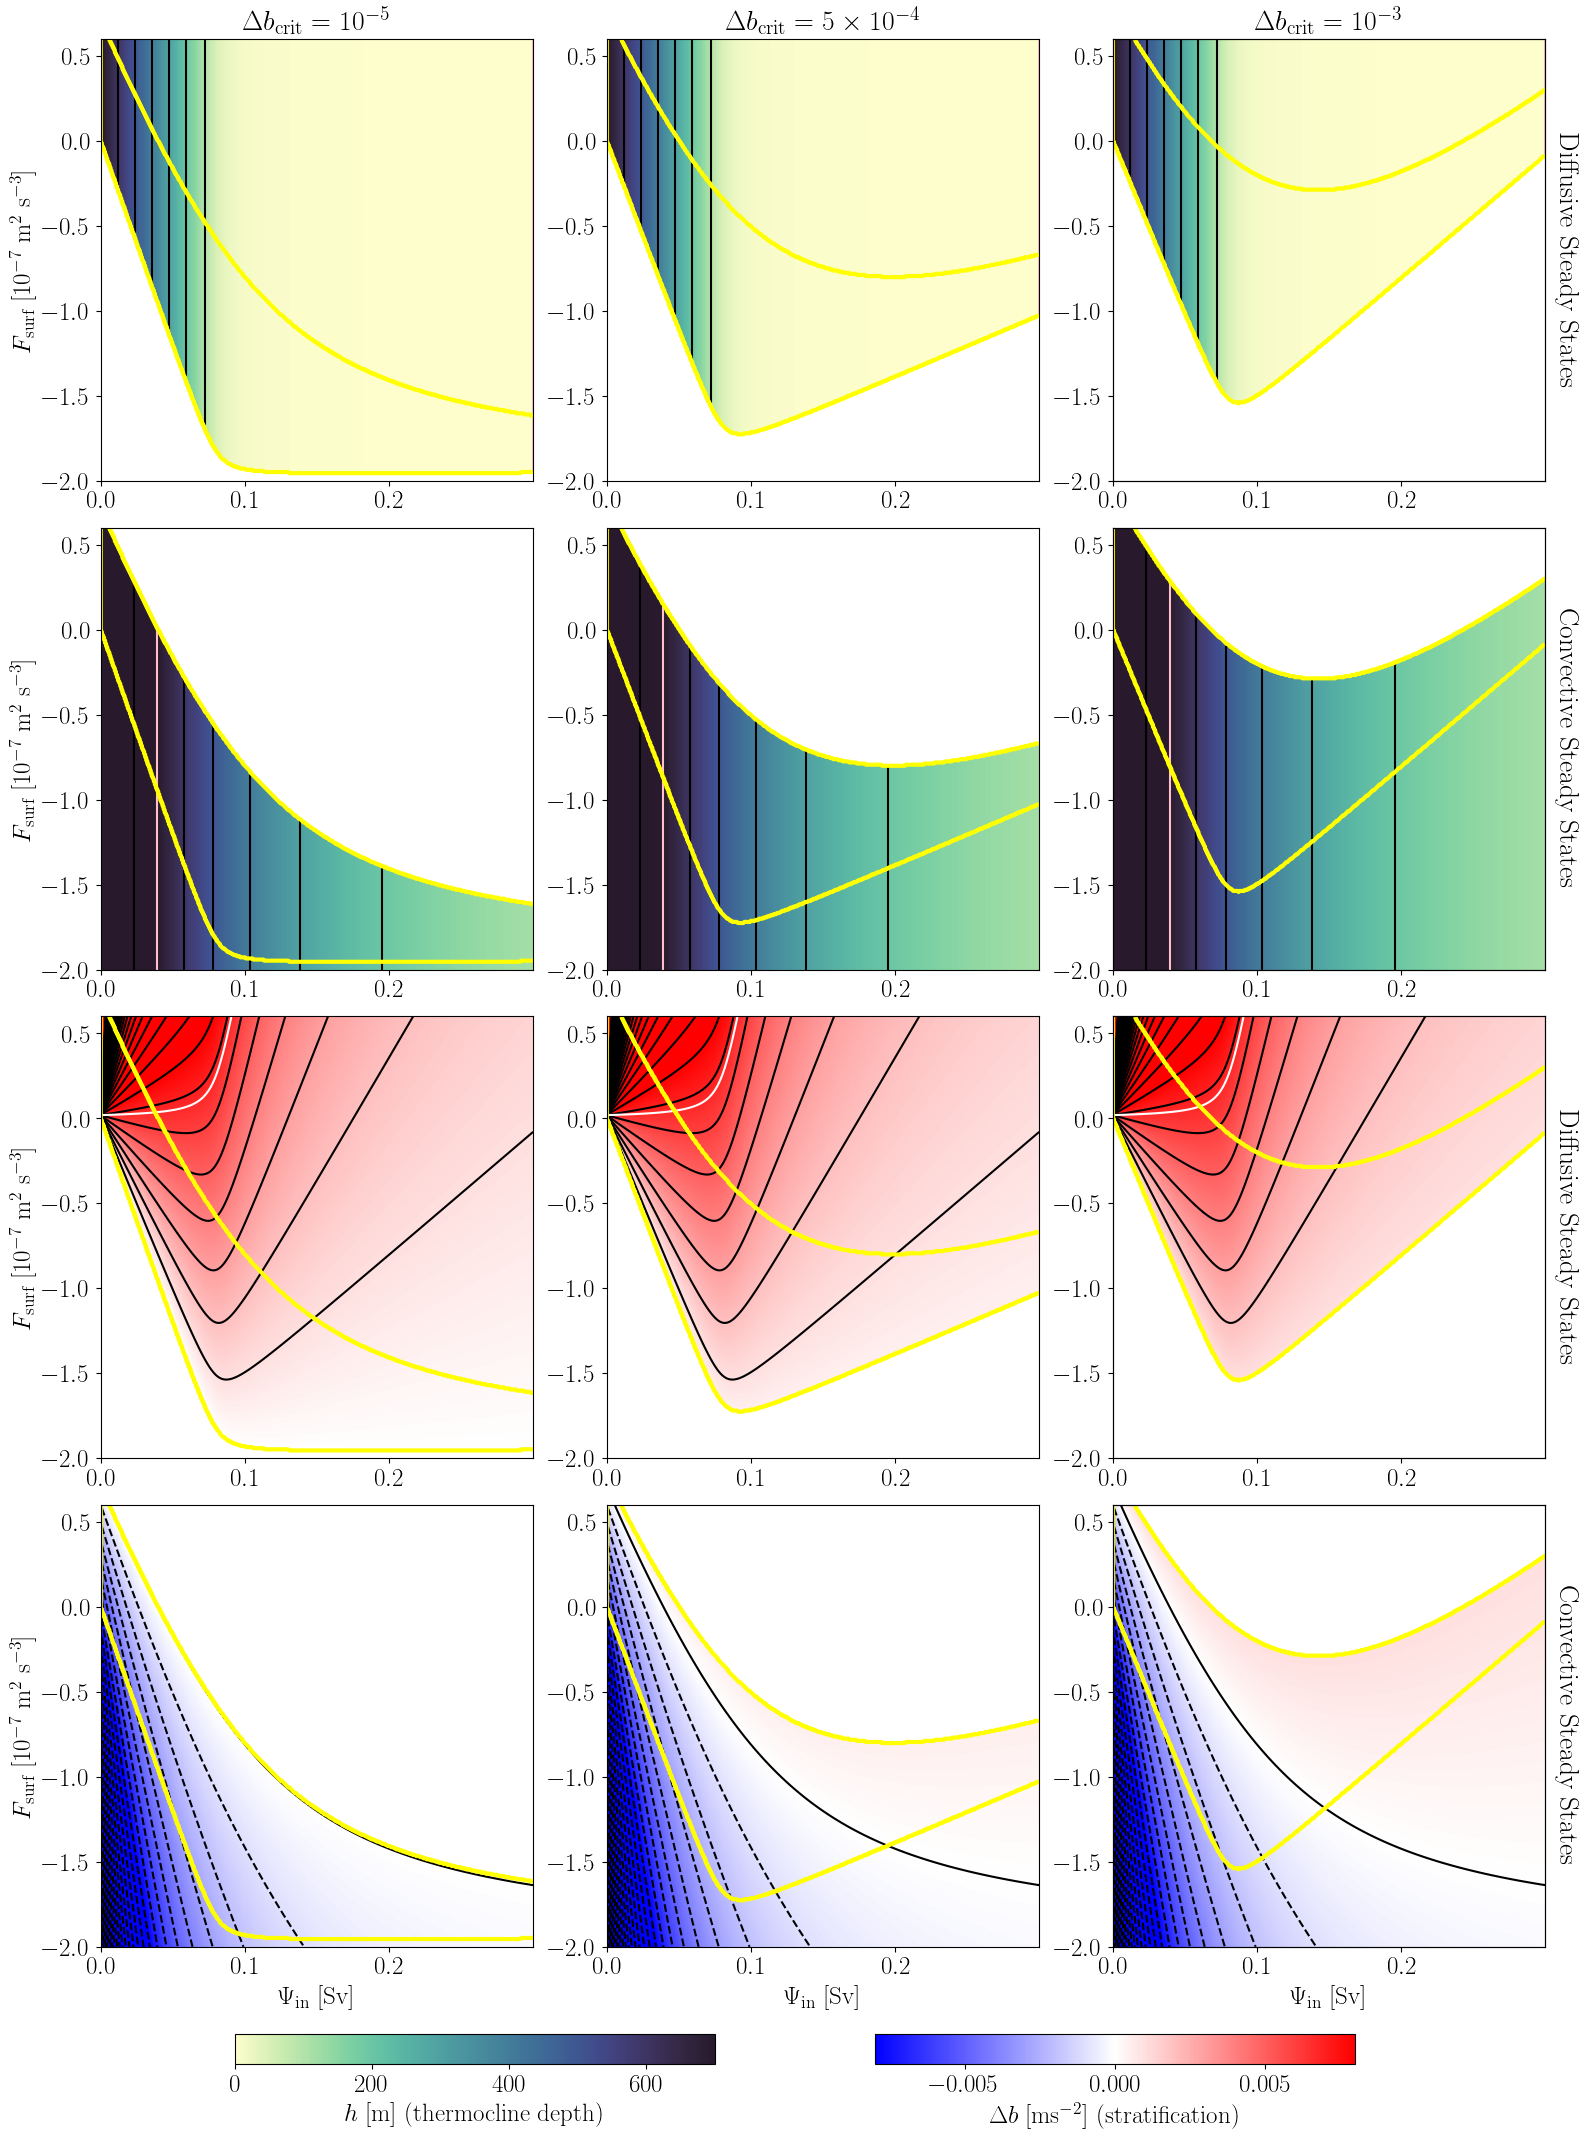

In [13]:
Ψin_min=0;Ψin_max=5.45;Fsurf_min=-2e-7;Fsurf_max=6e-8; n=400 

params_negative = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":1e-5, "ϕ":5e4, "α":0.0021}
params          = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
params_positive = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":1e-3, "ϕ":5e4, "α":0.0021}

ax,ax1,ax2 = sensitivity_plots(Ψin_min,Ψin_max,Fsurf_min,Fsurf_max, n, params, params_positive,params_negative)
ax.set_title(r'$\Delta b_\mathrm{crit}= 10^{-5}$',fontsize=20)
ax1.set_title(r'$\Delta b_\mathrm{crit}= 5\times 10^{-4}$',fontsize=20)
ax2.set_title(r'$\Delta b_\mathrm{crit}= 10^{-3}$',fontsize=20)
# plt.savefig('Figure_S3.png',bbox_inches = "tight")

plt.show()